In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("..")                    # Consistent with 01 and 02 notebooks
DATA = ROOT / "StudentProjectData"
RESULTS = ROOT / "results"
RESULTS.mkdir(exist_ok=True)

 Loader Utilities

In [2]:
# %%
def load_txt_matrix(path):
    """
    Loads a text file into a NumPy array.
    If the first line contains commas, treat it as CSV.
    Else treat as whitespace-separated text.
    """
    text = open(path).read()
    if "," in text.splitlines()[0]:
        return np.loadtxt(path, delimiter=",")
    return np.loadtxt(path)

def load_classification(i):
    """
    Load TrainData{i}, TrainLabel{i}, TestData{i}.
    Returns:
        X_train : (n_train, d)
        y_train : (n_train,)
        X_test  : (n_test, d)
    """
    X_train = load_txt_matrix(DATA / f"TrainData{i}.txt")
    y_train = load_txt_matrix(DATA / f"TrainLabel{i}.txt")
    X_test  = load_txt_matrix(DATA / f"TestData{i}.txt")
    return X_train, y_train.astype(int), X_test

Missing Value Handling (direct reuse from 02_missing_value.ipynb)

In [3]:
# %%
MISSING_MARKER = 1e99

def replace_missing_marker(X, marker=MISSING_MARKER):
    """
    Replace the 1e99 placeholder with np.nan for proper missing-value handling.
    """
    X = X.astype(float).copy()
    X[X == marker] = np.nan
    return X

In [4]:
print("Checking missing values in classification datasets (1e99 marker)...\n")
for i in range(1, 5):
    X_train, y_train, X_test = load_classification(i)
    
    train_missing = np.sum(X_train == MISSING_MARKER)
    test_missing  = np.sum(X_test  == MISSING_MARKER)

    print(f"Dataset {i}:")
    print(f"   Train missing values: {train_missing}")
    print(f"   Test missing values : {test_missing}\n")

Checking missing values in classification datasets (1e99 marker)...

Dataset 1:
   Train missing values: 9936
   Test missing values : 7021

Dataset 2:
   Train missing values: 0
   Test missing values : 0

Dataset 3:
   Train missing values: 1886
   Test missing values : 0

Dataset 4:
   Train missing values: 0
   Test missing values : 0



KNN Imputation

In [5]:
def knn_impute(X, k):
    """
    KNN Imputation for missing values (np.nan) in a 2D NumPy matrix.

    PARAMETERS:
        X : 2D numpy array, shape (num_rows, num_features)
            Contains real numbers and np.nan marking missing entries.

        k : int
            Number of neighbors to use for imputation.

    RETURNS:
        X_filled : 2D numpy array of same shape as X
            All np.nan replaced via KNN or column-mean fallback.
    """
    # 1. Create a copy of the original array:
    X_filled = X.copy()
    
    # 2. Identify which rows contain missing values
    #    This avoids scanning full rows multiple times unnecessarily.
    row_has_missing = np.isnan(X_filled).any(axis=1)
    
    # 3. Loop over rows
     # 3. Loop through each row (each sample)
    for i in range(X_filled.shape[0]):

        # If row i has no missing values → skip it
        if not row_has_missing[i]:
            continue

        # Extract the row vector
        row = X_filled[i]

        # Boolean masks: which features in this row are missing or valid
        missing_mask = np.isnan(row)      # True where row[i,f] is nan
        valid_mask   = ~missing_mask      # True where row[i,f] is known

        # If the row has *no valid features* at all (very rare),
        # we CANNOT compute distances with any neighbor.
        if valid_mask.sum() == 0:
            # Fallback: fill *every* missing feature with global column mean
            missing_cols = np.where(missing_mask)[0]
            for c in missing_cols:
                col_vals = X_filled[:, c]
                X_filled[i, c] = np.nanmean(col_vals)
            continue
        
        # 3.1 Build candidate neighbors:
        # rows that do NOT have missing values in valid features and are not i
        candidate_indices = []
        for j in range(X_filled.shape[0]):
            if j == i:
                continue  # skip itself

            other = X_filled[j]

            # We require that the neighbor row has NO missing values
            # in the "valid" dimensions of this row.
            # If it has missing in those dims → we CANNOT compare on equal footing.
            if np.isnan(other[valid_mask]).any():
                continue

            candidate_indices.append(j)
        
        # IF NO CANDIDATES EXIST → COLUMN MEAN FALLBACK
        if len(candidate_indices) == 0:
            # Identify missing columns for row i
            missing_cols = np.where(missing_mask)[0]

            # For each missing feature, fill using global column mean
            for c in missing_cols:
                col_vals = X_filled[:, c]
                col_mean = np.nanmean(col_vals)
                X_filled[i, c] = col_mean

            continue  # finished imputing row i; move to next row
        
        # 3.2 Compute distances vectorized over candidates
        # shape: (num_candidates, num_valid_features)
        # Extract only rows of candidate neighbors
        # but keep *only valid features* for distance computation
        candidate_matrix = X_filled[candidate_indices][:, valid_mask]
        
        # Target vector = row i, but only valid dims
        target_vector = row[valid_mask]
        
        # Compute differences between ALL candidates and the target
        diffs = candidate_matrix - target_vector  # broadcasting
        
        # Euclidean distance along feature axis
        dists = np.linalg.norm(diffs, axis=1)
        
        # 3.3 Choose up to k nearest neighbors
        order = np.argsort(dists)               # sorted by distance
        k_eff = min(k, len(order))              # handle case k > available neighbors
        local_neighbor_indices = order[:k_eff]  # local positions in candidate list
        
        # Convert local candidate positions → actual row indices
        neighbor_indices = [candidate_indices[idx] for idx in local_neighbor_indices]

        
        # 3.4 Impute each missing feature
        missing_cols = np.where(missing_mask)[0]
        
        for c in missing_cols:
            vals = []
            
            # Collect each neighbor's value in this column
            for ni in neighbor_indices:
                v = X_filled[ni, c]
                if not np.isnan(v):
                    vals.append(v)
            
            # Convert vals to array
            vals = np.array(vals)
            
            # Case 1: All neighbors have nan in this column → fallback again
            if vals.size == 0:
                 # fallback: global column mean for feature c
                col_vals = X_filled[:, c]
                col_mean = np.nanmean(col_vals)
                X_filled[i, c] = col_mean
                
            # Case 2: Normal case → average neighbor values
            else:
                X_filled[i, c] = np.mean(vals)
                
    return X_filled        
            

Helper Functions for Imputation K-selection (RMSE)

In [6]:
# ### 2.2 K-selection for Imputation (RMSE vs K)
# 
# We follow the same idea as in 02_missing_value.ipynb:
# - Work only on the *training* matrix X_train for a dataset.
# - Find rows with no missing values ("complete rows").
# - Hide a random subset of observed entries from those rows.
# - Impute the hidden values using different K.
# - Compare imputed values with original values → RMSE.
# - Choose the K with smallest RMSE.

# %%
def get_complete_rows(X):
    """
    Return indices of rows that contain NO missing values.
    """
    return np.where(~np.isnan(X).any(axis=1))[0]

def mask_from_complete_rows(X, complete_rows, fraction=0.05, seed=0):
    """
    Hide a fraction of observed entries ONLY in the complete rows.
    Returns:
        X_masked         : copy of X with some entries set to np.nan
        hidden_positions : list of (row, col) indices of hidden entries
    """
    rng = np.random.default_rng(seed)

    # All observed positions (non-NaN) in X
    observed = np.argwhere(~np.isnan(X))

    # Filter to only positions in complete rows
    observed = np.array([pos for pos in observed if pos[0] in complete_rows])

    # Number of positions to hide
    n_hide = int(len(observed) * fraction)
    chosen = rng.choice(len(observed), n_hide, replace=False)
    hidden_positions = observed[chosen]

    # Create masked copy
    X_masked = X.copy()
    for r, c in hidden_positions:
        X_masked[r, c] = np.nan

    return X_masked, hidden_positions

def evaluate_imputation_k(X, k, fraction=0.05, seed=0):
    """
    Evaluate K for imputation:
    - Works on matrix X (with NaNs).
    - Restrict hiding to rows that are fully observed.
    - Mask some known entries.
    - Impute with knn_impute using this K.
    - Compute RMSE on the hidden entries.
    """
    complete_rows = get_complete_rows(X)
    if len(complete_rows) == 0:
        # No complete rows → cannot evaluate; return big error
        return np.inf

    X_masked, hidden_positions = mask_from_complete_rows(
        X, complete_rows, fraction=fraction, seed=seed
    )

    X_imputed = knn_impute(X_masked, k=k)

    # Collect squared errors at hidden positions
    sq_errors = []
    for r, c in hidden_positions:
        true_val = X[r, c]
        pred_val = X_imputed[r, c]
        sq_errors.append((true_val - pred_val) ** 2)

    return np.sqrt(np.mean(sq_errors))

Imputation K-selection for Datasets 1 and 4


Imputation K-selection for Dataset 1


  K=1, RMSE=inf
  K=2, RMSE=inf
  K=3, RMSE=inf
  K=4, RMSE=inf
  K=5, RMSE=inf
  K=6, RMSE=inf
  K=7, RMSE=inf
  K=8, RMSE=inf
  K=9, RMSE=inf
  K=10, RMSE=inf


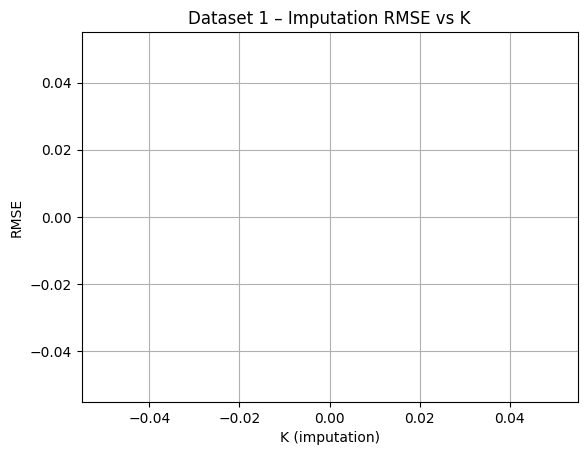

Best K_impute for Dataset 1 = 1

Imputation K-selection for Dataset 3
  K=1, RMSE=1.4254
  K=2, RMSE=1.2569
  K=3, RMSE=1.1809
  K=4, RMSE=1.1545
  K=5, RMSE=1.1199
  K=6, RMSE=1.1206
  K=7, RMSE=1.1039
  K=8, RMSE=1.1084
  K=9, RMSE=1.1072
  K=10, RMSE=1.1029


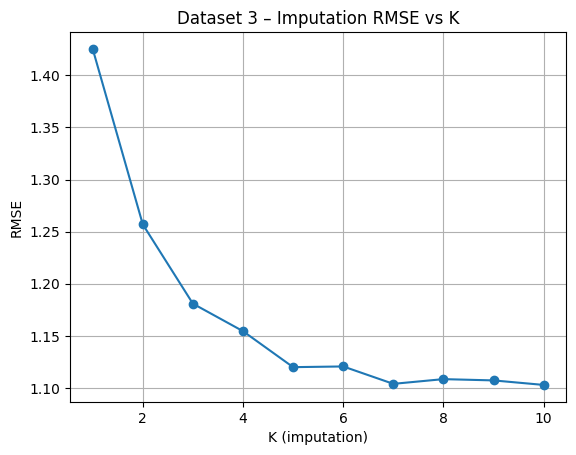

Best K_impute for Dataset 3 = 10


{1: 1, 3: 10}

In [7]:
# ### 2.3 Imputation K-selection for Dataset 1 and 3
# 
# Dataset 1 and 3 have missing values.
# We:
# - Use only the *training* matrix.
# - Convert 1e99 → NaN.
# - Evaluate K from 1 to 10.
# - Plot RMSE vs K.
# - Choose the K with smallest RMSE.

# %%
imputation_k_results = {}

for i in (1, 3):
    print("\n" + "="*40)
    print(f"Imputation K-selection for Dataset {i}")
    X_train_raw, y_train_raw, _ = load_classification(i)
    X_train_nan = replace_missing_marker(X_train_raw)

    Ks = list(range(1, 11))  # 1..10
    rmses = []

    for k in Ks:
        rmse = evaluate_imputation_k(X_train_nan, k=k, fraction=0.05, seed=42)
        rmses.append(rmse)
        print(f"  K={k}, RMSE={rmse:.4f}")

    # Plot RMSE vs K
    plt.figure()
    plt.plot(Ks, rmses, marker='o')
    plt.title(f"Dataset {i} – Imputation RMSE vs K")
    plt.xlabel("K (imputation)")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()

    # Choose best K (smallest RMSE)
    best_k = Ks[int(np.argmin(rmses))]
    imputation_k_results[i] = best_k
    print(f"Best K_impute for Dataset {i} = {best_k}")

imputation_k_results

In [8]:
# %%
def impute_dataset(X_train, X_test, k_impute=None):
    """
    Replace 1e99 → np.nan, then impute train and test.
    If k_impute is None: use simple column-mean imputation.
    Else: use KNN imputation with k_impute neighbors.
    """
    X_train = replace_missing_marker(X_train)
    X_test  = replace_missing_marker(X_test)

    if k_impute is None:
        col_means = np.nanmean(X_train, axis=0)

        def fill_mean(X):
            X_filled = X.copy()
            inds = np.where(np.isnan(X_filled))
            X_filled[inds] = np.take(col_means, inds[1])
            return X_filled

        return fill_mean(X_train), fill_mean(X_test)

    # KNN imputation
    return knn_impute(X_train, k_impute), knn_impute(X_test, k_impute)

Standardization (Training → Test)

In [9]:
# %%
def compute_standardization_params(X):
    mean = np.nanmean(X, axis=0)
    std  = np.nanstd(X, axis=0)
    std[std == 0] = 1.0
    return mean, std

def apply_standardization(X, mean, std):
    return (X - mean) / std

Full Preprocess Function Per Dataset

The Workflow: 

*  Load → replace missing marker → impute → standardize.

In [10]:
def preprocess_dataset(i, imputation_k_dict):
    """
    Preprocess a classification dataset:
      1. Load data
      2. Replace 1e99 → NaN
      3. Impute (mean or KNN depending on dataset)
      4. Standardize using training statistics

    PARAMETERS:
        i : dataset index {1,2,3,4}
        imputation_k_dict : dictionary holding best K per dataset,
                            or None where mean imputation should be used
                            e.g. {1: None, 2: None, 3: 3, 4: None}

    RETURNS:
        X_train_std, y_train, X_test_std
    """

    # Load raw matrices
    X_train_raw, y_train, X_test_raw = load_classification(i)

    # Decide imputation K for this dataset
    k_impute = imputation_k_dict.get(i, None)

    # Perform imputation
    X_train_imp, X_test_imp = impute_dataset(
        X_train_raw,
        X_test_raw,
        k_impute=k_impute
    )

    # Standardization (fit on training only)
    mean, std = compute_standardization_params(X_train_imp)
    X_train_std = apply_standardization(X_train_imp, mean, std)
    X_test_std  = apply_standardization(X_test_imp,  mean, std)

    return X_train_std, y_train.astype(int), X_test_std

---
#### CLASSIFICATION ALGORITHMS BEGIN:
---

#### KNN Classifier:

In [11]:
# %%
class KNNClassifier: 
    def __init__(self, k):
        self.k = k
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y.astype(int)
    
    def _predict_one(self, x):
        # Compute distances from x to every training sample
        diffs = self.X_train - x
        dists = np.linalg.norm(diffs, axis=1)

        # Select k nearest indices
        nn_idx = np.argsort(dists)[:self.k]
        nn_labels = self.y_train[nn_idx]

        # Majority vote
        labels, counts = np.unique(nn_labels, return_counts=True)
        return int(labels[np.argmax(counts)])
    
    def predict(self, X):
        return np.array([self._predict_one(x) for x in X], dtype=int)

Train/Validation Split + K Selection

We now create a stratified split so class proportions stay the same.
Then we test several values of K and choose the best one.

In [12]:
# %%
def stratified_train_val_split(X, y, val_ratio=0.2, seed=42):
    rng = np.random.RandomState(seed)
    y = y.astype(int)

    train_idx = []
    val_idx = []

    for c in np.unique(y):
        idx = np.where(y == c)[0]
        rng.shuffle(idx)
        n_val = int(len(idx) * val_ratio)
        val_idx.extend(idx[:n_val])
        train_idx.extend(idx[n_val:])

    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]


def select_k_for_dataset(X_train, y_train, k_values=(1, 3, 5, 7, 9)):
    X_tr, y_tr, X_val, y_val = stratified_train_val_split(X_train, y_train)

    best_acc = -1
    best_k = None

    for k in k_values:
        clf = KNNClassifier(k=k)
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        acc = (pred == y_val).mean()
        print(f"K={k}, validation accuracy={acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_k = k

    print(f"Best K for this dataset = {best_k}")
    return best_k

Run KNN on All 4 Datasets

In [13]:
def run_knn_for_all_datasets(best_k_3):
    """
    Execute KNN classification on all datasets 1..4:
        - preprocessing (imputation + standardization)
        - validation-based K selection
        - final predictions
        - save results
    """

    best_k_per_dataset = {}

    # Correct imputation K values
    imputation_k = {
        1: None,         # Dataset 1 → mean imputation only
        2: None,         # Dataset 2 → no missing
        3: best_k_3,     # Dataset 3 → real K from RMSE curve
        4: None          # Dataset 4 → no missing
    }

    for i in range(1, 5):
        print("\n" + "=" * 40)
        print(f"DATASET {i}")

        # Preprocess dataset (including correct imputation method)
        X_train, y_train, X_test = preprocess_dataset(i, imputation_k)

        # Validation-based K selection for classifier
        best_k = select_k_for_dataset(X_train, y_train)
        best_k_per_dataset[i] = best_k

        # Train final KNN classifier
        clf = KNNClassifier(k=best_k)
        clf.fit(X_train, y_train)

        # Predict test labels
        y_pred = clf.predict(X_test)

        # Save output file
        out_path = RESULTS / f"MadjitovClassification{i}.txt"
        np.savetxt(out_path, y_pred, fmt="%d")
        print(f"Saved predictions to: {out_path}")

    return best_k_per_dataset

KNN K-selection function with accuracy plot:

For each dataset `i`, we:
  1. Preprocess the dataset (impute + standardize)
  2. Split TRAIN into train/validation subsets
  3. Train KNN for various `k` values
  4. Measure validation accuracy
  5. Plot Accuracy vs K
  6. Return the best K

In [14]:
def evaluate_knn_k_values(X_train, y_train, k_list=(1,2,3,4,5,6,7,8,9,10,11,15), seed=42):
    """
    Evaluate KNN classifier accuracy for different K values.
    Returns:
        best_k : K with highest validation accuracy
        accuracies : list of validation accuracies per K
    """

    # Create stratified validation split
    X_tr, y_tr, X_val, y_val = stratified_train_val_split(
        X_train, y_train, val_ratio=0.2, seed=seed
    )

    accuracies = []

    print("\nEvaluating KNN classifier for various K values:\n")

    for k in k_list:
        clf = KNNClassifier(k=k)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        acc = (y_pred == y_val).mean()
        accuracies.append(acc)

        print(f"K={k:2d} → Validation Accuracy = {acc:.4f}")

    # Plot accuracy curve
    plt.figure(figsize=(6,4))
    plt.plot(k_list, accuracies, marker='o')
    plt.title("KNN Classifier – Validation Accuracy vs K")
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    # Best K
    best_idx = int(np.argmax(accuracies))
    best_k = k_list[best_idx]

    print(f"\nBest K = {best_k} with accuracy = {accuracies[best_idx]:.4f}\n")

    return best_k, accuracies

Run K-selection on a specific dataset i:


Evaluating KNN classifier for various K values:

K= 1 → Validation Accuracy = 0.9630
K= 2 → Validation Accuracy = 0.9259
K= 3 → Validation Accuracy = 1.0000
K= 4 → Validation Accuracy = 0.9630
K= 5 → Validation Accuracy = 1.0000


K= 6 → Validation Accuracy = 0.9259
K= 7 → Validation Accuracy = 0.9630
K= 8 → Validation Accuracy = 0.9630
K= 9 → Validation Accuracy = 0.9630
K=10 → Validation Accuracy = 0.8889
K=11 → Validation Accuracy = 0.9259
K=15 → Validation Accuracy = 0.9259


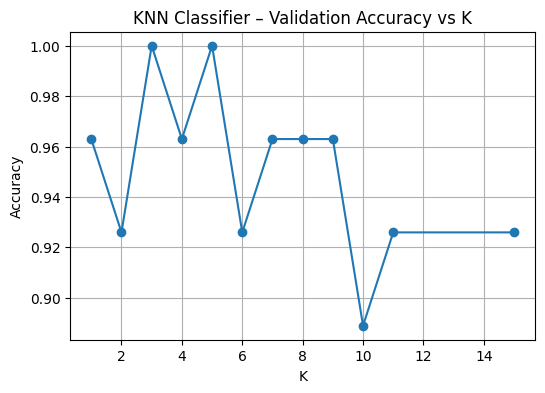


Best K = 3 with accuracy = 1.0000

Final chosen K for classifier on Dataset 1 = 3


In [15]:
i = 1   # <-- CHANGE THIS to 1, 2, 3, or 4

k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),   # your KNN imputation result
    4: None
}

# Preprocess dataset i (imputation + standardization)
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# Run K-selection FOR CLASSIFIER
best_k_i, accuracy_curve_i = evaluate_knn_k_values(X_train_i, y_train_i)

print(f"Final chosen K for classifier on Dataset {i} = {best_k_i}")

---
Accuracy TOO high !

---

Probably due to the imbalanced class distribution --> KNN memorizes on 1 dominating class

In [16]:
# ### Balanced Accuracy Metric
# Handles imbalanced classification better than raw accuracy.

# %%
def balanced_accuracy(y_true, y_pred):
    """
    Compute balanced accuracy:
        mean(recall per class)
    """
    classes = np.unique(y_true)
    recalls = []

    for c in classes:
        mask = (y_true == c)
        if mask.sum() == 0:
            continue
        recalls.append((y_pred[mask] == c).mean())

    return np.mean(recalls)

In [17]:
### Stratified K-Fold (5 folds)
def stratified_kfold(X, y, n_splits=5, seed=42):
    rng = np.random.RandomState(seed)
    y = y.astype(int)

    # Group samples by class
    class_indices = {c: np.where(y == c)[0].tolist() for c in np.unique(y)}
    for c in class_indices:
        rng.shuffle(class_indices[c])

    # Prepare folds
    folds = [[] for _ in range(n_splits)]

    # Distribute samples into folds in a round-robin way
    for c, indices in class_indices.items():
        for i, idx in enumerate(indices):
            folds[i % n_splits].append(idx)

    # Convert to numpy and build train/val splits
    for fold in range(n_splits):
        val_idx = np.array(folds[fold])
        train_idx = np.hstack([folds[i] for i in range(n_splits) if i != fold])
        yield train_idx, val_idx

 Improved KNN K-Selection with 5-Fold CV

In [18]:
def knn_k_selection_cv(X_train, y_train, k_list=(1,3,5,7,9,11,15), n_splits=5):
    print("\nRunning 5-Fold Cross-Validation for KNN K-selection...\n")

    cv_results = {k: [] for k in k_list}
    fold_accuracy_curves = []   # To store scores for each fold

    # --- Create 2x3 grid (6 subplots total) ---
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("KNN K-Selection — Balanced Accuracy by Fold", fontsize=18)
    axes = axes.flatten()

    # Perform Stratified K-Fold manually
    for fold, (train_idx, val_idx) in enumerate(stratified_kfold(X_train, y_train, n_splits=n_splits)):
        X_tr, y_tr = X_train[train_idx], y_train[train_idx]
        X_val, y_val = X_train[val_idx], y_train[val_idx]

        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        print("Validation class distribution:", np.unique(y_val, return_counts=True))

        fold_scores = []

        for k in k_list:
            clf = KNNClassifier(k)
            clf.fit(X_tr, y_tr)
            pred = clf.predict(X_val)

            score = balanced_accuracy(y_val, pred)
            fold_scores.append(score)
            cv_results[k].append(score)

            print(f"K={k:2d}, Balanced Accuracy={score:.4f}")

        fold_accuracy_curves.append(fold_scores)

        # ---- Plot this fold on assigned subplot ----
        ax = axes[fold]
        ax.plot(k_list, fold_scores, marker='o')
        ax.set_title(f"Fold {fold+1}", fontsize=14)
        ax.set_xlabel("K")
        ax.set_ylabel("Balanced Accuracy")
        ax.grid(True)

    # ---- Compute mean balanced accuracy per K ----
    avg_results = {k: np.mean(cv_results[k]) for k in k_list}

    print("\n=== Mean Balanced Accuracies Across All Folds ===")
    for k in k_list:
        print(f"K={k:2d}, Mean Balanced Accuracy={avg_results[k]:.4f}")

    best_k = max(avg_results, key=avg_results.get)
    print(f"\n>>> Best K = {best_k}  (Mean Balanced Accuracy = {avg_results[best_k]:.4f})\n")

    # ---- Plot in the 6th subplot: mean accuracy curve ----
    ax_mean = axes[5]
    ax_mean.plot(k_list, list(avg_results.values()), marker='o', color="red")
    ax_mean.set_title("Mean Balanced Accuracy (All Folds)", fontsize=14)
    ax_mean.set_xlabel("K")
    ax_mean.set_ylabel("Balanced Accuracy")
    ax_mean.grid(True)

    plt.tight_layout()
    plt.show()

    return best_k, avg_results

Report code:

In [19]:
def confusion_matrix(y_true, y_pred, n_classes):
    """
    Manual confusion matrix.
    Rows = true labels
    Columns = predicted labels
    """
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t-1, p-1] += 1   # labels are 1..C
    return cm


def precision_recall_f1_from_cm(cm):
    """
    Compute precision, recall, f1 *per class* and macro averages.
    Args:
        cm: confusion matrix (C x C)
    Returns:
        precision, recall, f1, macro_precision, macro_recall, macro_f1
    """

    n_classes = cm.shape[0]
    precision = np.zeros(n_classes)
    recall    = np.zeros(n_classes)
    f1        = np.zeros(n_classes)

    for c in range(n_classes):
        tp = cm[c, c]
        fp = cm[:, c].sum() - tp
        fn = cm[c, :].sum() - tp

        # Precision = TP / (TP + FP)
        precision[c] = tp / (tp + fp) if (tp + fp) > 0 else 0.0

        # Recall = TP / (TP + FN)
        recall[c] = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        # F1 = 2 * P * R / (P + R)
        if precision[c] + recall[c] > 0:
            f1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
        else:
            f1[c] = 0.0

    macro_precision = np.mean(precision)
    macro_recall    = np.mean(recall)
    macro_f1        = np.mean(f1)

    return precision, recall, f1, macro_precision, macro_recall, macro_f1


def full_classification_report(y_true, y_pred):
    """
    Produce a full printable evaluation report:
      - Confusion matrix
      - Accuracy
      - Precision/Recall/F1 for each class
      - Macro averages
    """
    classes = np.unique(y_true)
    C = len(classes)

    cm = confusion_matrix(y_true, y_pred, C)
    accuracy = (y_true == y_pred).mean()

    precision, recall, f1, macroP, macroR, macroF = precision_recall_f1_from_cm(cm)

    print("CONFUSION MATRIX (rows=true, cols=pred):")
    print(cm)
    print("\nACCURACY:", accuracy)

    print("\nPer-Class Metrics:")
    print("Class | Precision | Recall | F1")
    for i in range(C):
        print(f"{i+1:5d} | {precision[i]:9.3f} | {recall[i]:6.3f} | {f1[i]:5.3f}")

    print("\nMacro Averages (treat each class equally):")
    print(f"Macro Precision = {macroP:.3f}")
    print(f"Macro Recall    = {macroR:.3f}")
    print(f"Macro F1        = {macroF:.3f}")

    return {
        "cm": cm,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro_precision": macroP,
        "macro_recall": macroR,
        "macro_f1": macroF
    }

Run CV K-selection on any dataset i


Running 5-Fold Cross-Validation for KNN K-selection...




--- Fold 1/5 ---
Validation class distribution: (array([1, 2, 3, 4, 5]), array([22,  3,  3,  3,  1]))
K= 1, Balanced Accuracy=0.8667
K= 3, Balanced Accuracy=0.9333
K= 5, Balanced Accuracy=0.6667
K= 7, Balanced Accuracy=0.6667
K= 9, Balanced Accuracy=0.6667
K=11, Balanced Accuracy=0.6667
K=15, Balanced Accuracy=0.6000

--- Fold 2/5 ---
Validation class distribution: (array([1, 2, 3, 4, 5]), array([22,  3,  2,  3,  1]))
K= 1, Balanced Accuracy=1.0000
K= 3, Balanced Accuracy=0.8000
K= 5, Balanced Accuracy=0.8000
K= 7, Balanced Accuracy=0.8000
K= 9, Balanced Accuracy=0.5333
K=11, Balanced Accuracy=0.5333
K=15, Balanced Accuracy=0.5333

--- Fold 3/5 ---
Validation class distribution: (array([1, 2, 3, 4, 5]), array([22,  3,  2,  3,  1]))
K= 1, Balanced Accuracy=1.0000
K= 3, Balanced Accuracy=0.7000
K= 5, Balanced Accuracy=0.8000
K= 7, Balanced Accuracy=0.8000
K= 9, Balanced Accuracy=0.8000
K=11, Balanced Accuracy=0.7000
K=15, Balanced Accuracy=0.6000

--- Fold 4/5 ---
Validation class distr

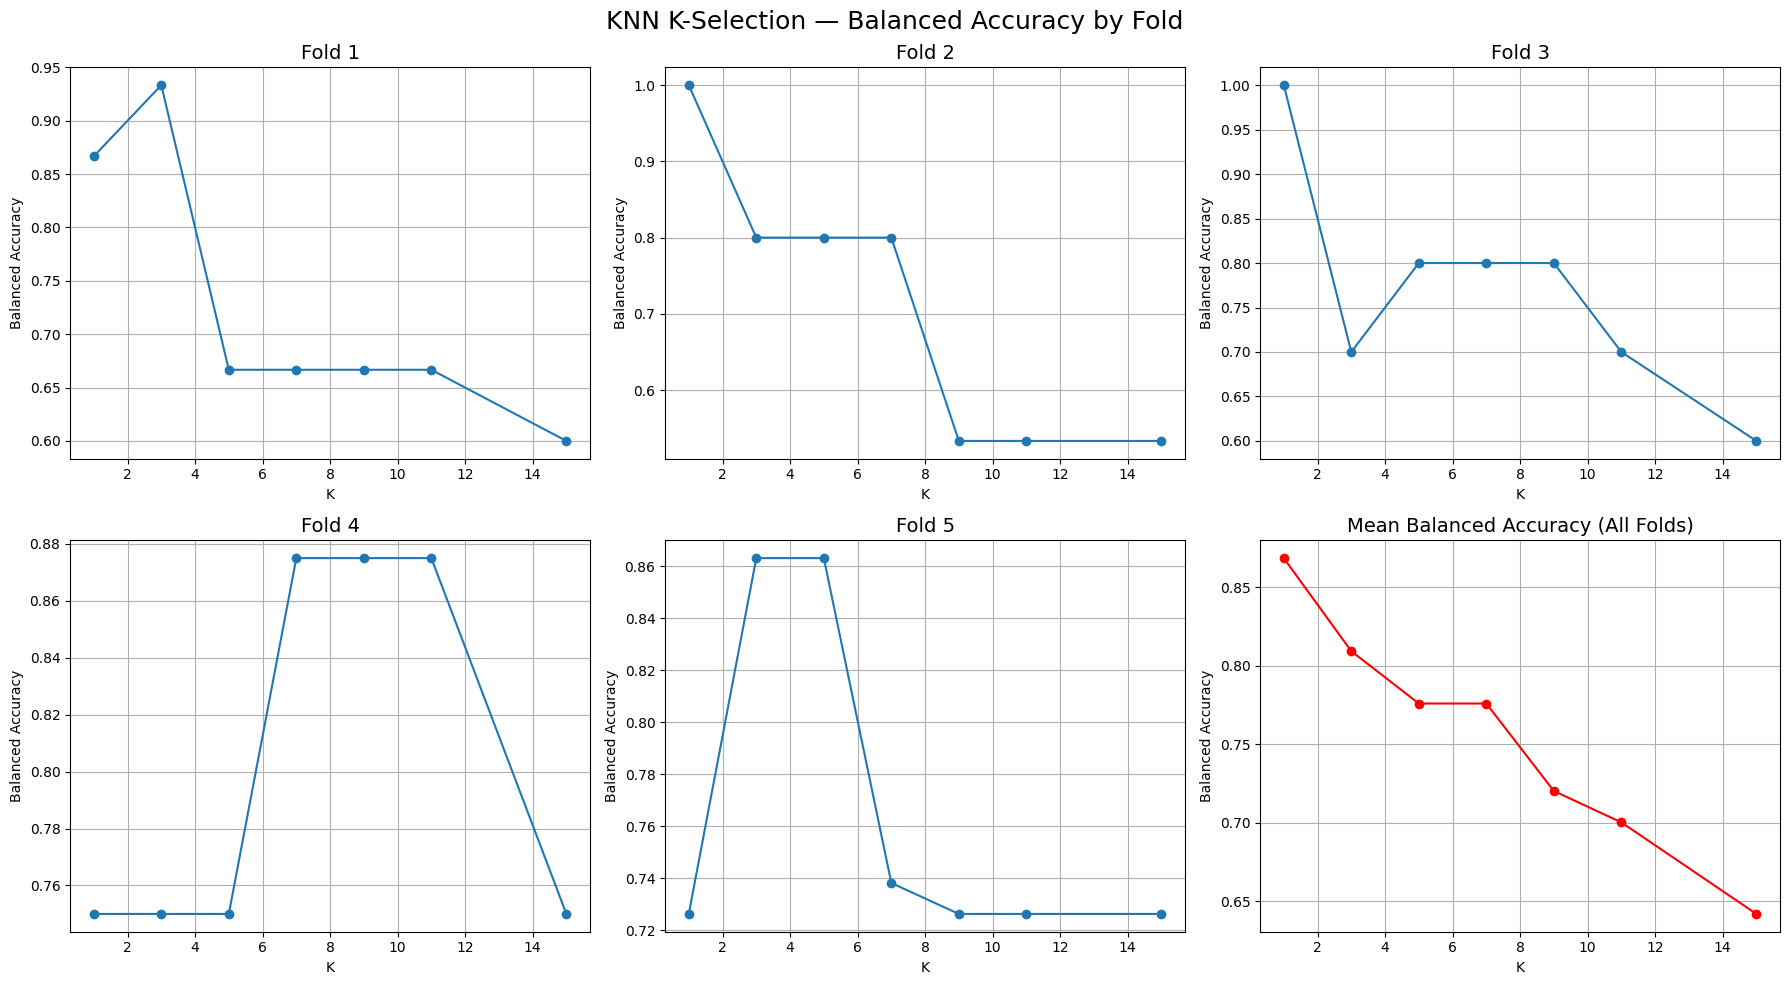


Final chosen K for classifier on Dataset 1 = 1


In [20]:
i = 1 

k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

# Preprocess for dataset i
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# Run 5-fold CV K-selection
best_k_i, cv_scores_i = knn_k_selection_cv(X_train_i, y_train_i)

print(f"\nFinal chosen K for classifier on Dataset {i} = {best_k_i}")

In [21]:
# Full dataset
X_train_full = X_train_i
y_train_full = y_train_i

# Fresh 80/20 validation (not used in training K-selection)
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_full, y_train_full, val_ratio=0.2, seed=123
)

clf = KNNClassifier(k=best_k_i)
clf.fit(X_tr_chk, y_tr_chk)

pred_val = clf.predict(X_val_chk)

report = full_classification_report(y_val_chk, pred_val)

CONFUSION MATRIX (rows=true, cols=pred):
[[21  0  0  0]
 [ 0  2  0  0]
 [ 1  0  1  0]
 [ 0  0  0  2]]

ACCURACY: 0.9629629629629629

Per-Class Metrics:
Class | Precision | Recall | F1
    1 |     0.955 |  1.000 | 0.977
    2 |     1.000 |  1.000 | 1.000
    3 |     1.000 |  0.500 | 0.667
    4 |     1.000 |  1.000 | 1.000

Macro Averages (treat each class equally):
Macro Precision = 0.989
Macro Recall    = 0.875
Macro F1        = 0.911



Running 5-Fold Cross-Validation for KNN K-selection...


--- Fold 1/5 ---
Validation class distribution: (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2]))
K= 1, Balanced Accuracy=0.8182
K= 3, Balanced Accuracy=0.7424
K= 5, Balanced Accuracy=0.6212
K= 7, Balanced Accuracy=0.6212
K= 9, Balanced Accuracy=0.6212
K=11, Balanced Accuracy=0.6667
K=15, Balanced Accuracy=0.6212

--- Fold 2/5 ---
Validation class distribution: (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([2, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2]))
K= 1, Balanced Accuracy=0.8788
K= 3, Balanced Accuracy=0.9242
K= 5, Balanced Accuracy=0.8182
K= 7, Balanced Accuracy=0.8182
K= 9, Balanced Accuracy=0.8182
K=11, Balanced Accuracy=0.7273
K=15, Balanced Accuracy=0.6818

--- Fold 3/5 ---
Validation class distribution: (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2]))
K= 1, Balanced Accuracy=0.7727
K= 3, Balanced Accuracy=0.6818
K= 5, Balanc

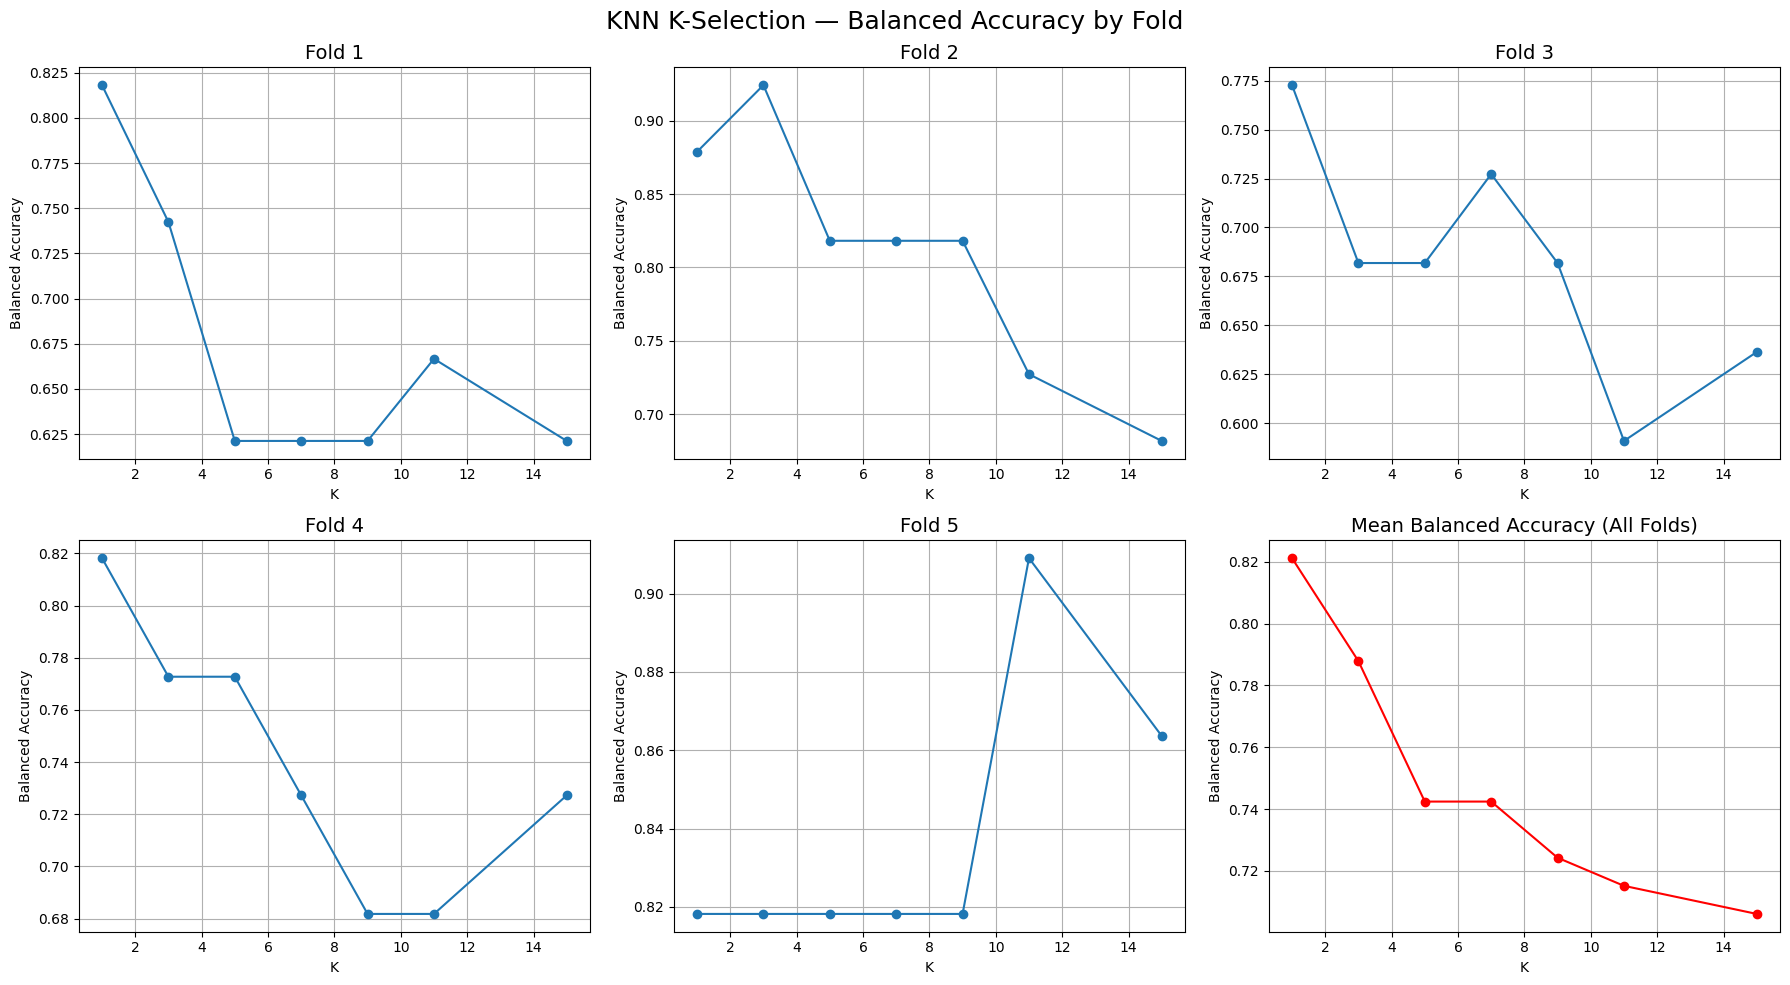


Final chosen K for classifier on Dataset 2 = 1


In [22]:
i = 2 

k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

# Preprocess for dataset i
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# Run 5-fold CV K-selection
best_k_i, cv_scores_i = knn_k_selection_cv(X_train_i, y_train_i)

print(f"\nFinal chosen K for classifier on Dataset {i} = {best_k_i}")

In [23]:
# Full dataset
X_train_full = X_train_i
y_train_full = y_train_i

# Fresh 80/20 validation (not used in training K-selection)
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_full, y_train_full, val_ratio=0.2, seed=123
)

clf = KNNClassifier(k=best_k_i)
clf.fit(X_tr_chk, y_tr_chk)

pred_val = clf.predict(X_val_chk)

report = full_classification_report(y_val_chk, pred_val)

CONFUSION MATRIX (rows=true, cols=pred):
[[2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]]

ACCURACY: 0.75

Per-Class Metrics:
Class | Precision | Recall | F1
    1 |     1.000 |  1.000 | 1.000
    2 |     0.000 |  0.000 | 0.000
    3 |     1.000 |  1.000 | 1.000
    4 |     0.400 |  1.000 | 0.571
    5 |     1.000 |  0.500 | 0.667
    6 |     1.000 |  1.000 | 1.000
    7 |     1.000 |  1.000 | 1.000
    8 |     1.000 |  1.000 | 1.000
    9 |     1.000 |  1.000 | 1.000
   10 |     0.000 |  0.000 | 0.000
   11 |     0.000 |  0.000 | 0.000

Macro Averages (treat each class equally):
Macro Precision = 0.673
Macro Recall    = 0.682
Macro F1        = 0.658



Running 5-Fold Cross-Validation for KNN K-selection...


--- Fold 1/5 ---
Validation class distribution: (array([1, 2, 3, 4, 5, 6, 7, 8, 9]), array([247, 111,  98, 114,  99, 156, 136, 183, 120]))
K= 1, Balanced Accuracy=0.2207
K= 3, Balanced Accuracy=0.2409
K= 5, Balanced Accuracy=0.2538
K= 7, Balanced Accuracy=0.2431
K= 9, Balanced Accuracy=0.2550
K=11, Balanced Accuracy=0.2558
K=15, Balanced Accuracy=0.2569

--- Fold 2/5 ---
Validation class distribution: (array([1, 2, 3, 4, 5, 6, 7, 8, 9]), array([247, 111,  98, 113,  99, 156, 136, 183, 119]))
K= 1, Balanced Accuracy=0.2359
K= 3, Balanced Accuracy=0.2261
K= 5, Balanced Accuracy=0.2391
K= 7, Balanced Accuracy=0.2394
K= 9, Balanced Accuracy=0.2531
K=11, Balanced Accuracy=0.2528
K=15, Balanced Accuracy=0.2596

--- Fold 3/5 ---
Validation class distribution: (array([1, 2, 3, 4, 5, 6, 7, 8, 9]), array([247, 111,  98, 113,  99, 155, 135, 182, 119]))
K= 1, Balanced Accuracy=0.2234
K= 3, Balanced Accuracy=0.2303
K= 5, Balanced Accuracy=0.2

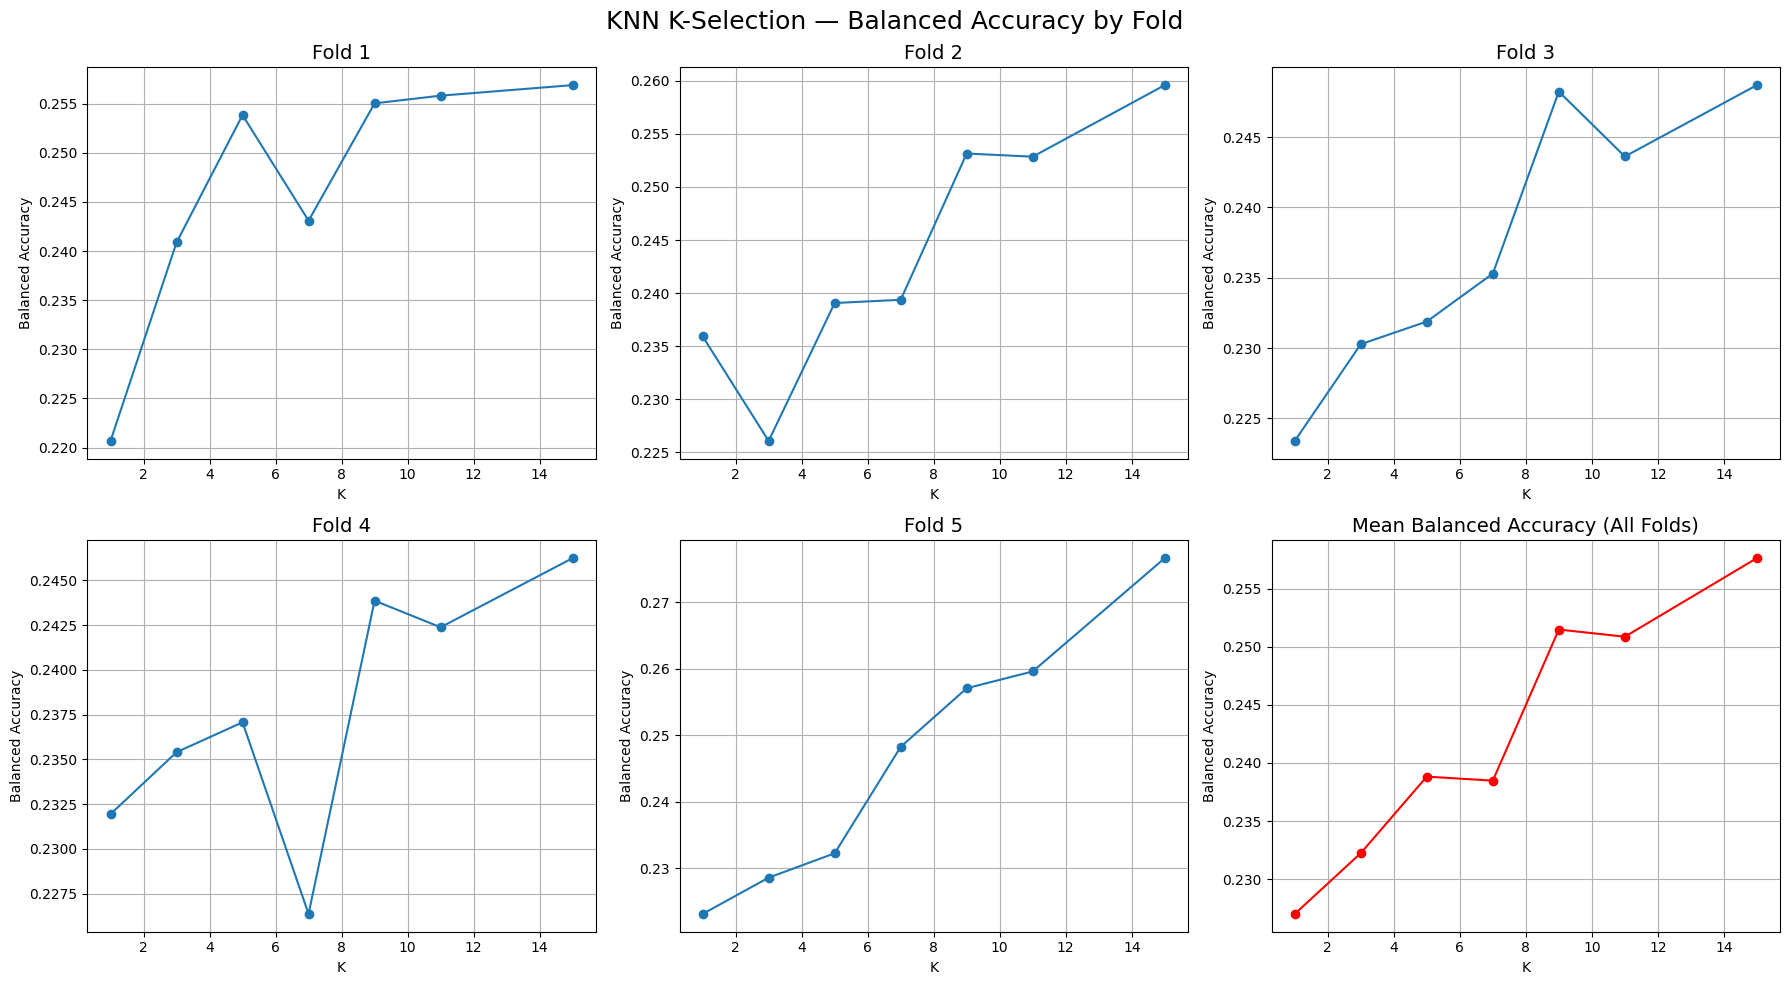


Final chosen K for classifier on Dataset 3 = 15


In [24]:
i = 3

k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

# Preprocess for dataset i
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# Run 5-fold CV K-selection
best_k_i, cv_scores_i = knn_k_selection_cv(X_train_i, y_train_i)

print(f"\nFinal chosen K for classifier on Dataset {i} = {best_k_i}")

In [25]:
# Full dataset
X_train_full = X_train_i
y_train_full = y_train_i

# Fresh 80/20 validation (not used in training K-selection)
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_full, y_train_full, val_ratio=0.2, seed=123
)

clf = KNNClassifier(k=best_k_i)
clf.fit(X_tr_chk, y_tr_chk)

pred_val = clf.predict(X_val_chk)

report = full_classification_report(y_val_chk, pred_val)

CONFUSION MATRIX (rows=true, cols=pred):
[[192  14  15   9   3   8   3   3   0]
 [ 44  14  10  10   7  11   3   8   3]
 [ 28  13  10  17   8   9   4   7   1]
 [ 18  15  14  18   9  14   9  14   2]
 [ 16   4  10  22   9  18  10   8   2]
 [ 15   7   9  13  11  37  17  41   5]
 [ 14   5   3  15   7  29  18  33  11]
 [ 21   3   5   9   0  26  24  64  30]
 [ 19   2   1   4   3  11  11  38  30]]

ACCURACY: 0.3118536197295147

Per-Class Metrics:
Class | Precision | Recall | F1
    1 |     0.523 |  0.777 | 0.625
    2 |     0.182 |  0.127 | 0.150
    3 |     0.130 |  0.103 | 0.115
    4 |     0.154 |  0.159 | 0.157
    5 |     0.158 |  0.091 | 0.115
    6 |     0.227 |  0.239 | 0.233
    7 |     0.182 |  0.133 | 0.154
    8 |     0.296 |  0.352 | 0.322
    9 |     0.357 |  0.252 | 0.296

Macro Averages (treat each class equally):
Macro Precision = 0.245
Macro Recall    = 0.248
Macro F1        = 0.241



Running 5-Fold Cross-Validation for KNN K-selection...


--- Fold 1/5 ---
Validation class distribution: (array([1, 2, 3, 4, 5, 6, 7, 8, 9]), array([58, 55, 54, 59, 56, 58, 58, 60, 54]))
K= 1, Balanced Accuracy=0.8661
K= 3, Balanced Accuracy=0.8672
K= 5, Balanced Accuracy=0.8592
K= 7, Balanced Accuracy=0.8550
K= 9, Balanced Accuracy=0.8574
K=11, Balanced Accuracy=0.8478
K=15, Balanced Accuracy=0.8378

--- Fold 2/5 ---
Validation class distribution: (array([1, 2, 3, 4, 5, 6, 7, 8, 9]), array([58, 55, 54, 59, 56, 58, 58, 60, 54]))
K= 1, Balanced Accuracy=0.8391
K= 3, Balanced Accuracy=0.8370
K= 5, Balanced Accuracy=0.8345
K= 7, Balanced Accuracy=0.8170
K= 9, Balanced Accuracy=0.8128
K=11, Balanced Accuracy=0.8089
K=15, Balanced Accuracy=0.8012

--- Fold 3/5 ---
Validation class distribution: (array([1, 2, 3, 4, 5, 6, 7, 8, 9]), array([58, 55, 54, 58, 56, 57, 58, 60, 54]))
K= 1, Balanced Accuracy=0.8361
K= 3, Balanced Accuracy=0.8319
K= 5, Balanced Accuracy=0.8536
K= 7, Balanced Accuracy

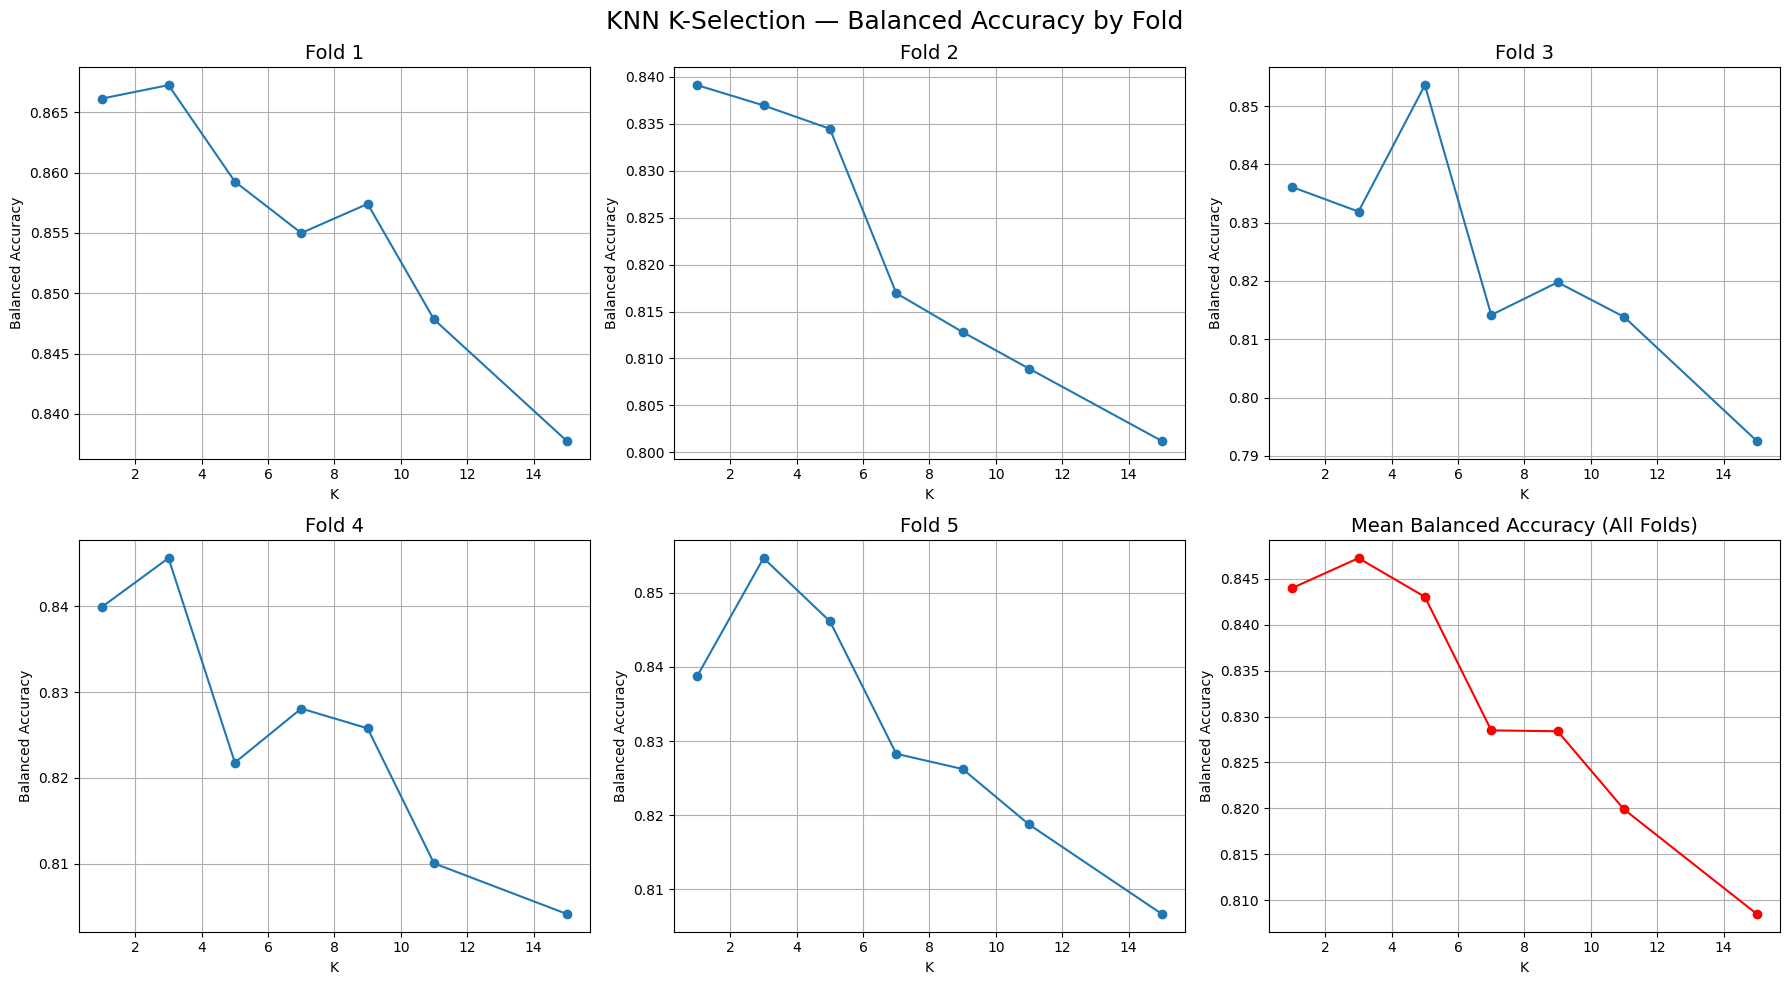


Final chosen K for classifier on Dataset 4 = 3


In [26]:
i = 4

k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

# Preprocess for dataset i
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# Run 5-fold CV K-selection
best_k_i, cv_scores_i = knn_k_selection_cv(X_train_i, y_train_i)

print(f"\nFinal chosen K for classifier on Dataset {i} = {best_k_i}")

In [27]:
# After running CV and getting best_k_i

# Full dataset for training
X_train_full = X_train_i
y_train_full = y_train_i

# Create a fresh 80/20 validation set for evaluation
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_full, y_train_full, val_ratio=0.2, seed=123
)

# Train final classifier on the training portion
clf = KNNClassifier(k=best_k_i)
clf.fit(X_tr_chk, y_tr_chk)

# Evaluate on the held-out validation set
pred_val = clf.predict(X_val_chk)

# Print complete metrics
report = full_classification_report(y_val_chk, pred_val)

CONFUSION MATRIX (rows=true, cols=pred):
[[44  4  2  7  0  0  0  0  0]
 [ 7 41  6  0  1  0  0  0  0]
 [ 2  5 47  0  0  0  0  0  0]
 [ 2  0  1 50  5  0  0  0  0]
 [ 0  0  1  3 49  2  0  0  0]
 [ 0  1  0  1  9 46  0  0  0]
 [ 0  0  0  0  1  0 52  3  1]
 [ 0  0  0  0  0  1  2 55  1]
 [ 0  0  0  0  0 10  1  5 38]]

ACCURACY: 0.83399209486166

Per-Class Metrics:
Class | Precision | Recall | F1
    1 |     0.800 |  0.772 | 0.786
    2 |     0.804 |  0.745 | 0.774
    3 |     0.825 |  0.870 | 0.847
    4 |     0.820 |  0.862 | 0.840
    5 |     0.754 |  0.891 | 0.817
    6 |     0.780 |  0.807 | 0.793
    7 |     0.945 |  0.912 | 0.929
    8 |     0.873 |  0.932 | 0.902
    9 |     0.950 |  0.704 | 0.809

Macro Averages (treat each class equally):
Macro Precision = 0.839
Macro Recall    = 0.833
Macro F1        = 0.833


In [28]:
# ============================================================
# FINAL KNN PREDICTIONS — DATASET 3 (K = 15)
# ============================================================

print("\n=== Final KNN Pipeline for Dataset 3 ===")

# Correct K for imputation and classification
K_IMPUTE_3 = imputation_k_results.get(3, None)   # from missing-value notebook
K_CLASSIFIER_3 = 15                               # from your CV & final report

# 1. Preprocess dataset 3 (impute + standardize)
k_impute_dict = {
    1: None,
    2: None,
    3: K_IMPUTE_3,
    4: None
}

X_train_3, y_train_3, X_test_3 = preprocess_dataset(3, k_impute_dict)

# 2. Train final KNN classifier
clf3 = KNNClassifier(k=K_CLASSIFIER_3)
clf3.fit(X_train_3, y_train_3)

# 3. Predict test labels
y_pred_3 = clf3.predict(X_test_3)

# 4. Save final output
out3 = RESULTS / "MadjitovClassification3.txt"
np.savetxt(out3, y_pred_3.astype(int), fmt="%d")

print("Saved:", out3)


=== Final KNN Pipeline for Dataset 3 ===
Saved: ../results/MadjitovClassification3.txt


In [29]:
# ============================================================
# FINAL KNN PREDICTIONS — DATASET 4 (K = 3)
# ============================================================

print("\n=== Final KNN Pipeline for Dataset 4 ===")

K_IMPUTE_4 = None                 # no missing values in dataset 4
K_CLASSIFIER_4 = 3                # from your CV & final report

# 1. Preprocess dataset 4
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

X_train_4, y_train_4, X_test_4 = preprocess_dataset(4, k_impute_dict)

# 2. Train final KNN classifier
clf4 = KNNClassifier(k=K_CLASSIFIER_4)
clf4.fit(X_train_4, y_train_4)

# 3. Predict test labels
y_pred_4 = clf4.predict(X_test_4)

# 4. Save final output
out4 = RESULTS / "MadjitovClassification4.txt"
np.savetxt(out4, y_pred_4.astype(int), fmt="%d")

print("Saved:", out4)


=== Final KNN Pipeline for Dataset 4 ===
Saved: ../results/MadjitovClassification4.txt
